In [97]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pprint
import csv
import datetime
import math




In [98]:
# import and process new data

In [99]:
def extract_time(t1,t2,t3=None,t4=None):
    
    try:
        t1 = datetime.datetime.strptime(t1, "%Y-%m-%d %H:%M:%S.%f")
    except:
        t1 = datetime.datetime.strptime(t1, "%Y-%m-%d %H:%M:%S")
        
    try:
        t2  = datetime.datetime.strptime(t2, "%Y-%m-%d %H:%M:%S.%f")
    except:
        t2  = datetime.datetime.strptime(t2, "%Y-%m-%d %H:%M:%S")
        
    if t3 is not None:
        
        try:
            t3   = datetime.datetime.strptime(t3, "%Y-%m-%d %H:%M:%S.%f")
        except:
            t3   = datetime.datetime.strptime(t3, "%Y-%m-%d %H:%M:%S")
        
        try:
            t4  = datetime.datetime.strptime(t4, "%Y-%m-%d %H:%M:%S.%f")
        except:
            t4  = datetime.datetime.strptime(t4, "%Y-%m-%d %H:%M:%S")
            
            
        return ((t2-t1)+(t4-t3)).total_seconds()
    
    else:
        return (t2-t1).total_seconds()

In [100]:
def extract_core_overhead(df):
    alloc_start,alloc_stop,dealloc_start,dealloc_stop = df['timestamp']
    core_ov = extract_time(alloc_start,alloc_stop,dealloc_start,dealloc_stop)
    
    return core_ov

In [102]:
def extract_pat_overhead(df):
    pre_loop_df = df[0:1]
    sim_df = df[1:7]
    ana_df = df[7:]
    
    #start,wait,res,stop = pre_loop_df['timestamp']    
    #pre_loop_ov = extract_time(start,wait,res,stop)
    
    
    #print sim_df['timestamp']
    
    start1,wait1,res1,stop1,start2,stop2 = sim_df['timestamp']
    part1 = extract_time(start1,wait1,res1,stop1)
    #part2 = extract_time(start2,wait2,res2,stop2)
    #post = extract_time(post_start,post_stop)    
    sim_ov = part1 #+ part2 + post

    start1,wait1,res1,stop1,start2,stop2 = ana_df['timestamp']
    part1 = extract_time(start1,wait1,res1,stop1)
    #part2 = extract_time(start2,wait2,res2,stop2)
    #post = extract_time(post_start,post_stop)    
    ana_ov = part1 #+ part2 + post
    
    return sim_ov+ana_ov
    

In [103]:
def extract_timing_info(df,cores,inst):
    
    preloop_data,sim_data,ana_data = extract_data_time(df,cores,inst)
    preloop_exec,sim_exec,ana_exec = extract_exec_time(df,cores,inst)
    
    return [preloop_data,sim_data,ana_data],[preloop_exec,sim_exec,ana_exec]

,step,kernel,probe,timestamp
iteration,,,,
None,pre_loop,None,start_time,2015-09-29 11:49:46.608063
1,sim,kernel_0,start_time,2015-09-29 11:49:46.610365
1,sim,kernel_0,wait_time,2015-09-29 11:49:46.638068
1,sim,kernel_0,res_time,2015-09-29 11:49:52.015048
1,sim,kernel_0,stop_time,2015-09-29 11:49:52.016546
1,sim,post,start_time,2015-09-29 11:49:52.016599
1,sim,post,stop_time,2015-09-29 11:49:52.020523
1,ana,kernel_0,start_time,2015-09-29 11:49:52.021701
1,ana,kernel_0,wait_time,2015-09-29 11:49:52.048790


In [104]:
def extract_data_time(df,cores,inst):
    req_df = df[['step','StagingInput','Allocating','PendingAgentOutputStaging','Done']]
    
    preloop_df = req_df[:1]
    sim_df = req_df[1:-2]
    ana_df = req_df[-2:]
    
    preloop_data = None
    sim_data = None
    ana_data = None
    
    
    # Preloop extraction
    step,t1,t2,t3,t4 =  preloop_df.loc[0,:]
    preloop_data = extract_time(t1,t2,t3,t4)
    
    
    #Simulation extraction
    per_unit_data_time  = list()
    for row in sim_df.iterrows():
        step,t1,t2,t3,t4 = row[1:][0]
        #print t1,t2,t3,t4
        #print row
        per_unit_data_time.append(extract_time(t1,t2,t3,t4))
        
    if cores == inst:
        kern_1 = per_unit_data_time[:inst]
        kern_2 = per_unit_data_time[inst:]
        sim_data = np.average(kern_1) + np.average(kern_2)
    elif inst > cores:
        pass
    
    
    #Analysis extraction
    per_unit_data_time  = list()
    for row in ana_df.iterrows():
        step,t1,t2,t3,t4 = row[1:][0]
        #print t1,t2,t3,t4
        #print row
        per_unit_data_time.append(extract_time(t1,t2,t3,t4))
        
    ana_data = sum(per_unit_data_time)
    
    #print preloop_data, sim_data, ana_data
    return preloop_data, sim_data, ana_data

In [105]:
def extract_exec_time(df,cores,inst):
    req_df = df[['step','Executing','PendingAgentOutputStaging']]
    
    preloop_df = req_df[:1]
    sim_df = req_df[1:-2]
    ana_df = req_df[-2:]
    
    preloop_exec = None
    sim_exec = None
    ana_exec = None
    
    
    # Preloop extraction
    step,t1,t2 =  preloop_df.loc[0,:]
    preloop_exec = extract_time(t1,t2)

    
    #Simulation extraction
    #STUPID ME SET CORES PER CU = 2!!
    per_unit_exec_time  = list()
    for row in sim_df.iterrows():
        step,t1,t2 = row[1:][0]
        #print t1,t2,t3,t4
        #print row
        per_unit_exec_time.append(extract_time(t1,t2))
        
    if cores == inst:
        kern_1 = per_unit_exec_time[:inst]
        kern_2 = per_unit_exec_time[inst:]
        sim_exec = (np.average(kern_1) + np.average(kern_2))*2
    elif inst > cores:
        pass
    
  
    
    #Analysis extraction
    per_unit_exec_time  = list()
    for row in ana_df.iterrows():
        step,t1,t2 = row[1:][0]
        #print t1,t2,t3,t4
        #print row
        per_unit_exec_time.append(extract_time(t1,t2))
        
    ana_exec = sum(per_unit_exec_time)
    
    
    #print preloop_exec, sim_exec, ana_exec
    return preloop_exec, sim_exec, ana_exec

In [106]:
def extract_rp_overhead(df,data,exec_list):
    
    pre_loop_df = df[0:1]
    sim_df = df[1:7]
    ana_df = df[7:]
  
    '''
    start,wait,res,stop = pre_loop_df['timestamp'] 
    preloop_wait = extract_time(wait,res)
    preloop_rp_ov = preloop_wait - data[0] - exec_list[0]
    '''
    
    start1,wait1,res1,stop1,start2,stop2 = sim_df['timestamp']
    sim_wait = extract_time(wait1,res1)
    sim_rp_ov = sim_wait - data[1] - exec_list[1]
    
    start1,wait1,res1,stop1,start2,stop2 = ana_df['timestamp']
    ana_wait = extract_time(wait1,res1)
    ana_rp_ov = ana_wait - data[2] - exec_list[2]
    
    
    print sim_wait, data[1], exec_list[1]
    rp_ov = sim_rp_ov + ana_rp_ov
    
    
    #print preloop_rp_ov, sim_rp_ov, ana_rp_ov
    
    return rp_ov

In [107]:
def split_plot(ov,app,data):
    fig, axes = plt.subplots(nrows=3, ncols=1)
    ax1 = ov[0].plot(ax=axes[0],kind='bar',stacked=False,
               title='Overhead: Amber-CoCo MD application implemented with Simulation-Analysis-Loop pattern on Stampede',
               colors=['black','green','red'],ylim=(0,200),fontsize=14,rot=0,yerr=ov[1])
    ax2 = app[0].plot(ax=axes[1],kind='bar',stacked=False,
               title='Application: Amber-CoCo MD application implemented with Simulation-Analysis-Loop pattern on Stampede',
               colors=['purple','blue','yellow'],ylim=(0,2500),fontsize=14,rot=0,yerr=app[1])
    ax3 = data[0].plot(ax=axes[2],kind='bar',stacked=False,
               title='Data Movement: Amber-CoCo MD application implemented with Simulation-Analysis-Loop pattern on Stampede',
               colors=['brown'],ylim=(0,100),fontsize=14,rot=0,yerr=data[1])
    
    ax2.set_xlabel('Cores/No. of simulations',fontsize=14)
    ax2.set_ylabel('Time (seconds)',fontsize=14)
    ax2.legend(fontsize=14,loc='upper left')
    ax2.set_title(ax2.get_title(),fontsize=14)
    ax1.set_xlabel('Cores/No. of simulations',fontsize=14)
    ax1.set_ylabel('Time (seconds)',fontsize=14)
    ax1.legend(fontsize=14,loc='upper left')
    ax1.set_title(ax1.get_title(),fontsize=14)
    ax3.set_xlabel('Cores/No. of simulations',fontsize=14)
    ax3.set_ylabel('Time (seconds)',fontsize=14)
    ax3.legend(fontsize=14,loc='upper left')
    ax3.set_title(ax3.get_title(),fontsize=14)

In [108]:
def separate(comp_df,err_df):
    ov_df = pd.DataFrame(columns=['EnMD Core overhead',
                                'EnMD Pat overhead',
                                'RP overhead'])
    ov_df_err = pd.DataFrame(columns=['EnMD Core overhead',
                                'EnMD Pat overhead',
                                'RP overhead'])
    ov_df['EnMD Core overhead'] = comp_df['EnMD Core overhead']
    ov_df['EnMD Pat overhead'] = comp_df['EnMD Pat overhead']
    ov_df['RP overhead'] = comp_df['RP overhead']
    
    ov_df_err['EnMD Core overhead'] = err_df['EnMD Core overhead']
    ov_df_err['EnMD Pat overhead'] = err_df['EnMD Pat overhead']
    ov_df_err['RP overhead'] = err_df['RP overhead']
    
    
    
    app_df = pd.DataFrame(columns=['pre_loop execution time',
                                'sim execution time',
                                'ana execution time'])
    app_df_err = pd.DataFrame(columns=['pre_loop execution time',
                                'sim execution time',
                                'ana execution time'])
    app_df['pre_loop execution time'] = comp_df['pre_loop execution time']
    app_df['sim execution time'] = comp_df['sim execution time']
    app_df['ana execution time'] = comp_df['ana execution time']
    
    app_df_err['pre_loop execution time'] = err_df['pre_loop execution time']
    app_df_err['sim execution time'] = err_df['sim execution time']
    app_df_err['ana execution time'] = err_df['ana execution time']
    
    
    
    data_df = pd.DataFrame(columns=['data movement'])
    data_df_err = pd.DataFrame(columns=['data movement'])
    data_df['data movement'] = comp_df['data movement']
    data_df_err['data movement'] = err_df['data movement']
    
    split_plot([ov_df,ov_df_err],[app_df,app_df_err],[data_df,data_df_err])

In [109]:
#MAIN

comp_df = pd.DataFrame(columns=['EnMD Core overhead',
                                'EnMD Pat overhead',
                                'RP overhead',
                                'pre_loop execution time',
                                'sim execution time',
                                'ana execution time',
                                'data movement'])

err_df = pd.DataFrame(columns=['EnMD Core overhead',
                                'EnMD Pat overhead',
                                'RP overhead',
                                'pre_loop execution time',
                                'sim execution time',
                                'ana execution time',
                                'data movement'])

cores = [1,16,32,64,128]
trials = 4
for c in cores:
    
    core_ov_list = list()
    pat_ov_list = list()
    rp_ov_list = list()
    data_list = list()
    preloop_exec_list = list()
    sim_exec_list = list()
    ana_exec_list = list()
    
    for t in range(1,trials+1):
        
        #f_core = open('experiment_iter{0}_p{1}_i{1}/enmd_core_overhead.csv'.format(t,c))
        df_core = pd.read_csv('sa_data/enmd_core_overhead_{0}_{1}.csv'.format(c,t),header=0,sep=',')
        df_pat = pd.read_csv('sa_data/enmd_pat_overhead_{0}_{1}.csv'.format(c,t),header=0,sep=',')
        df_profile = pd.read_csv('sa_data/profile_{0}_{1}.csv'.format(c,t),header=0,sep=',',
                            skipinitialspace=True)
        core_ov = extract_core_overhead(df_core)
        pat_ov = extract_pat_overhead(df_pat)
        data, exec_list = extract_timing_info(df_profile,cores=c,inst=c)
        rp_ov = extract_rp_overhead(df_pat,data,exec_list)
        
        core_ov_list.append(core_ov)
        pat_ov_list.append(pat_ov)
        rp_ov_list.append(rp_ov)
        preloop_exec_list.append(exec_list[0])
        sim_exec_list.append(exec_list[1])
        ana_exec_list.append(exec_list[2])
        data_list.append(sum(data))
        #print rp_ov_list
        
    #print 'Core ov: ',core_ov_list
    #print 'Pat ov: ',pat_ov_list
    #print 'Data mov: ',data_list
    #print 'Preloop exec: ',preloop_exec_list
    #print 'Sim exec: ',sim_exec_list
    #print 'Ana exec: ',ana_exec_list
    
    comp_df.loc['{0}/{1}'.format(c,c)] = [np.average(core_ov_list),
                                          np.average(pat_ov_list),
                                          np.average(rp_ov_list),
                                          np.average(preloop_exec_list),
                                          np.average(sim_exec_list),
                                          np.average(ana_exec_list),
                                          np.average(data_list)]
    
    err_df.loc['{0}/{1}'.format(c,c)] = [
                                          np.std(core_ov_list)/math.sqrt(trials),
                                          np.std(pat_ov_list)/math.sqrt(trials),
                                          np.std(rp_ov_list)/math.sqrt(trials),
                                          np.std(preloop_exec_list)/math.sqrt(trials),
                                          np.std(sim_exec_list)/math.sqrt(trials),
                                          np.std(ana_exec_list)/math.sqrt(trials),
                                          np.std(data_list)/math.sqrt(trials)
                                         ]



5.37698 nan nan
4.936494 nan nan
5.026981 nan nan
5.586535 nan nan
16.212191 8.16758173077 19.3973653846
13.850372 6.78890865385 19.026375
16.99094 8.41829326923 20.2884326923
14.148711 7.54847115385 19.5798461538
18.580043 13.2222974138 20.0753900862
17.809915 14.1288071121 19.0921918103
16.58956 10.4179094828 24.0789073276
18.96141 14.6543631466 20.5577198276
16.584786 20.5062702357 20.8965471311
15.395167 18.5914159836 19.696973873
16.524493 25.8374446721 21.4649579918
16.524493 25.8374446721 21.4649579918
18.46385 48.0909639375 21.467964875
33.134296 48.9764561875 27.05601125
20.625358 49.0429909375 20.908778
18.46385 48.0909639375 21.467964875


In [131]:
comp_df['RP overhead'][0] = .5
for i in range(0,len(comp_df['RP overhead'])):
    comp_df['RP overhead'][i] = abs(comp_df['RP overhead'][i])
    
comp_df['sim execution time'][0] = 18.318947
comp_df['data movement'][0] = 13.592614
comp_df


,EnMD Core overhead,EnMD Pat overhead,RP overhead,pre_loop execution time,sim execution time,ana execution time,data movement
1/1,18.910957,0.051109,0.500000,1.72700,18.318947,2.57825,13.592614
16/16,18.527207,0.401730,12.633012,9.80575,19.573005,1.41000,21.103314
32/32,18.466658,0.804841,16.254910,9.97175,20.951052,1.38000,34.000344
64/64,19.596101,1.806192,38.040015,10.25650,20.880859,1.12600,75.141894
128/128,20.422284,4.268570,44.616128,10.30625,22.725180,1.84850,147.556844


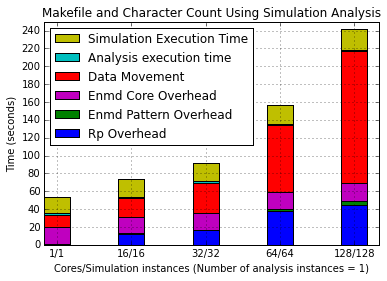

In [139]:
N = 5
ind = np.arange(N)
width = .35

rp_overhead = comp_df['RP overhead']
enmd_pattern_overhead = comp_df['EnMD Pat overhead']
enmd_core_overhead = comp_df['EnMD Core overhead']
movement = comp_df['data movement']
analysis = comp_df['ana execution time']
simulation = comp_df['sim execution time']

rp_overhead_graphs = ()
for i in range(0,len(rp_overhead)):
    temp = (plt.bar(i,rp_overhead[i],width,color='b'))
    rp_overhead_graphs = rp_overhead_graphs + temp

enmd_pattern_overhead_graphs = ()
for i in range(0,len(enmd_pattern_overhead)):
    temp = (plt.bar(i,enmd_pattern_overhead[i],width,color='g',bottom = rp_overhead[i]))
    enmd_pattern_overhead_graphs = enmd_pattern_overhead_graphs + temp

enmd_core_overhead_graphs = ()
for i in range(0,len(enmd_core_overhead)):
    temp = (plt.bar(i,enmd_core_overhead[i],width,color='m',bottom = rp_overhead[i] + enmd_pattern_overhead[i]))
    enmd_core_overhead_graphs = enmd_core_overhead_graphs + temp

m_graphs = ()
for i in range(0,len(movement)):
    offset = rp_overhead[i] + enmd_pattern_overhead[i] + enmd_core_overhead[i]
    temp = (plt.bar(i,movement[i],width,color='r',bottom=offset))
    m_graphs = m_graphs + temp
    
a_graphs = ()
for i in range(0,len(analysis)):
    
    
    offset = rp_overhead[i] + enmd_pattern_overhead[i] + enmd_core_overhead[i] + movement[i]
    temp = (plt.bar(i,analysis[i],width,color='c',bottom=offset))
    a_graphs = a_graphs + temp

s_graphs = ()
for i in range(0,len(simulation)):
    
    #print analysis[i], movement[i]
    offset = rp_overhead[i] + enmd_pattern_overhead[i] + enmd_core_overhead[i] + movement[i] + analysis[i]
    temp = (plt.bar(i,simulation[i],width,color='y',bottom=offset))
    s_graphs = s_graphs + temp

legend_titles = ('Simulation Execution Time', 'Analysis execution time', 'Data Movement','Enmd Core Overhead', 'Enmd Pattern Overhead','Rp Overhead')
legend_tuples = (s_graphs[0], a_graphs[0], m_graphs[0],enmd_core_overhead_graphs[0], enmd_pattern_overhead_graphs[0],rp_overhead_graphs[0])

plt.ylabel('Time (seconds)')
plt.xlabel('Cores/Simulation instances (Number of analysis instances = 1)')
plt.title('Makefile and Character Count Using Simulation Analysis')
plt.xticks(ind+width/2., ('1/1', '16/16', '32/32', '64/64', '128/128') )
plt.yticks(np.arange(0,250,20))
plt.legend(legend_tuples,legend_titles,loc='upper left')
plt.grid()
#plt.legend( (p1[0], p2[0],p3[3]), ('Data Movement', 'Analysis execution time', 'Simulation Execution time'), loc='upper left' )
#plt.legend( (t1[0]), ('Data Movement', 'Analysis execution time', 'Simulation Execution time'), loc='upper left' )
#rp_overhead[i] + enmd_pattern_overhead[i]plt.savefig("/home/nikhil/Documents/research/enmd-pattern-testing/apes_sc15/img/sa_graph.png")
plt.savefig('img/sa_weak_scaling.png')